# Predict (Forecast)

### Setup

In [123]:
# import pandas
import pandas as pd

# matplotlib
%matplotlib inline
import matplotlib
plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams['figure.facecolor'] = 'white'

# import requests
import requests

# import prophet
from prophet import Prophet
from prophet.serialize import model_from_json

# misc
import os
from dotenv import load_dotenv
load_dotenv()
import pickle
import numpy as np

### Retrieve 3-day Forecast

In [124]:
res = requests.get('https://api.weatherapi.com/v1/forecast.json?key={}&q=Callicoon, NY&days=3&aqi=no&alerts=no'.format(os.environ['WEATHER_KEY']))

forecast_raw = []
for day in res.json()['forecast']['forecastday']:
  forecast_raw += day['hour']

forecast = {}
for hour in forecast_raw:
  airtemp = hour['temp_c']
  cloudcover = hour['cloud'] * (4 / 100)
  precip = 0
  if (hour['will_it_rain']): precip = 2
  elif (hour['will_it_snow']): precip = 3

  forecast[pd.to_datetime(hour['time'])] = {
    'airtemp': airtemp,
    'cloudcover': cloudcover,
    'precip': precip
  }

forecast_df = pd.DataFrame.from_dict(forecast, orient='index')
forecast_df = forecast_df.resample('15min').interpolate('linear')

forecast_df = forecast_df.reset_index()
forecast_df = forecast_df.rename(columns={'index': 'ds'})

# add the last three days of historical observations to the prediction frame
# load observations df
observations = pd.read_pickle('output/observations.pickle')

last_three_days = observations.tail(4 * 24 * 3)
last_three_days_actual = last_three_days['107337_00065']
last_three_days = last_three_days.drop(columns=['107337_00065', '107338_00010'])
last_three_days['ds'] = pd.to_datetime(last_three_days['ds']).dt.tz_localize(None)

forecast_df = pd.concat((forecast_df.loc[forecast_df['ds'] > last_three_days['ds'].iat[-1]], last_three_days))
print(forecast_df.head(), forecast_df.tail())

                    ds  airtemp  cloudcover  precip
89 2022-07-28 22:15:00   18.975        3.31     0.5
90 2022-07-28 22:30:00   18.850        3.22     1.0
91 2022-07-28 22:45:00   18.725        3.13     1.5
92 2022-07-28 23:00:00   18.600        3.04     2.0
93 2022-07-28 23:15:00   18.500        3.06     1.5                         ds    airtemp  cloudcover  precip
507638 2022-07-28 21:00:00  26.277778    1.666667     0.0
507639 2022-07-28 21:15:00  25.533333    2.000000     0.0
507640 2022-07-28 21:30:00  24.788889    2.333333     0.0
507641 2022-07-28 21:45:00  24.044444    2.666667     0.0
507642 2022-07-28 22:00:00  23.300000    3.000000     0.0


### Retrieve Model and Scaler

In [125]:
with open('output/model.json') as f:
  model = model_from_json(f.read())

/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/serialize.py:136: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(attr_dict[attribute]))


### Scale Forecast Data

In [126]:
# values = forecast_df.values
# values = values.astype('float')

# scaled = in_scaler.transform(values)

# input = pd.DataFrame(scaled, columns=['var1(t-1)', 'var2(t-1)', 'var3(t-1)'])
# test_X = input.values.reshape((input.shape[0], 1, input.shape[1]))
# print(test_X)

### Run Prediction

/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


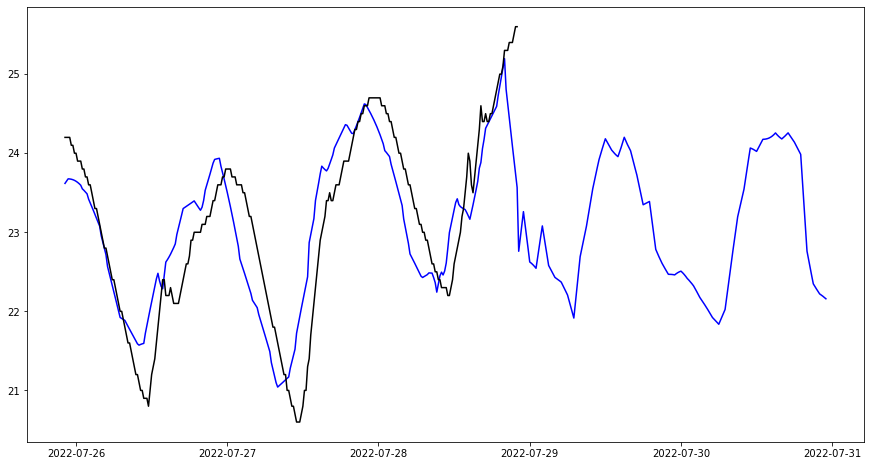

/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


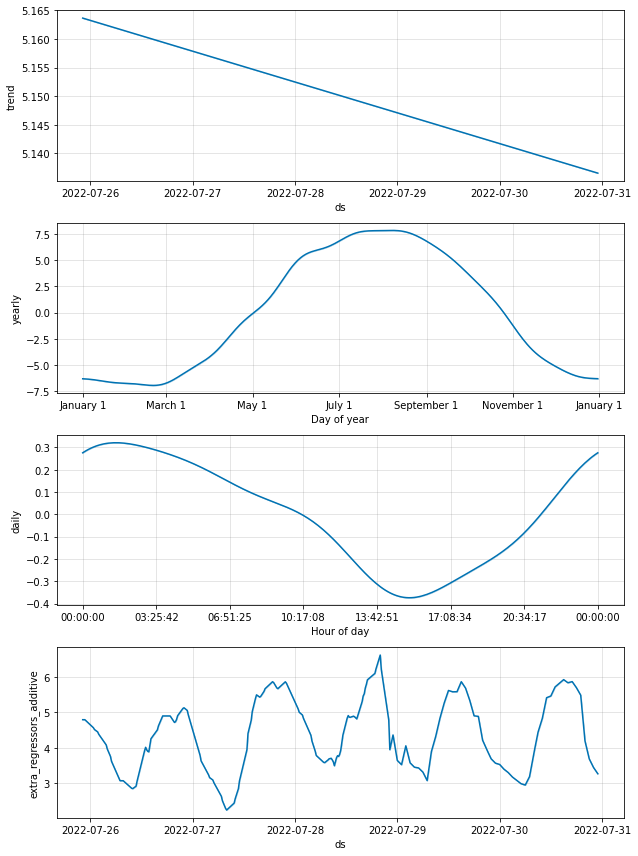

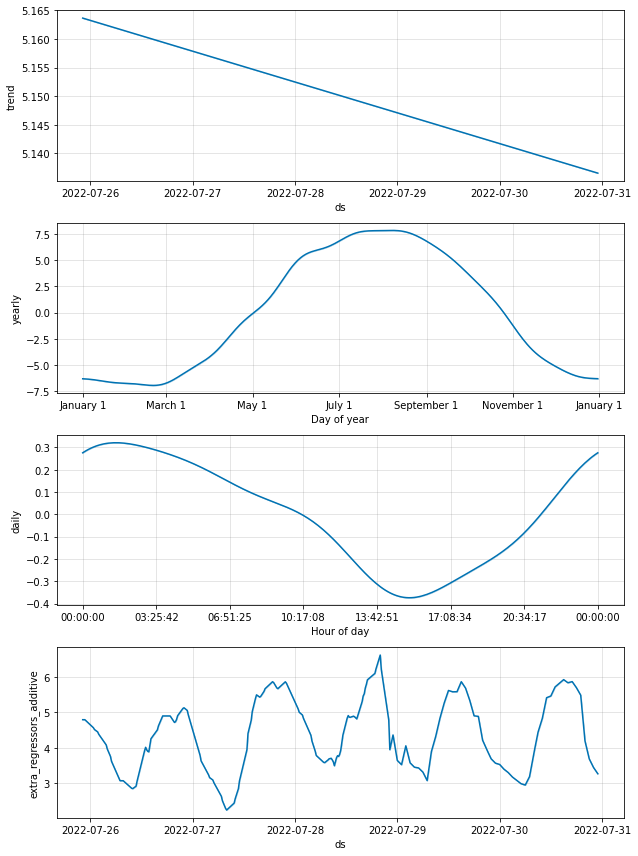

In [129]:
pred = model.predict(forecast_df)

delta = last_three_days_actual.values - pred.iloc[:last_three_days.shape[0]]['yhat'].values
avg_delta = np.average(delta)
pred_adjusted = pred['yhat'].apply(lambda v: v + avg_delta)

plt.plot(pred['ds'], pred_adjusted, color='blue')
plt.plot(last_three_days['ds'], last_three_days_actual, color='black')
# plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='blue', alpha=0.15)
plt.show()

model.plot_components(pred)